# Sections

[Objective](#Objective)  
[Setup](#Setup)  
[Load data](#Load-data)  
[Scratchpad](#Scratchpad)

# Objective
[Back to top](#Sections)

#### How much interest will a new rental listing on RentHop receive?

In this Kaggle <a href='https://www.kaggle.com/c/two-sigma-connect-rental-listing-inquiries/data'>competition</a>, the aim is to predict how popular an apartment rental listing is based on the listing content like text description, photos, number of bedrooms, price, etc.

This workbook explores whether there are any insights to be gained from the text descripiton.

#  Setup
[Back to top](#Sections)

In [1]:
from __future__ import print_function, division

In [2]:
from collections import namedtuple
from collections import OrderedDict
from collections import Counter
import numpy as np
import pandas as pd

Load functions for producing nicely formatted output.

In [3]:
# %load utils.py
from IPython.display import display, HTML

def pp_bold(str):
    display(HTML('<b>{}</b>'.format(str)))


def pp_listOflist(l):
    display(HTML(
        u'<table>{}</table>'.format(
            u''.join(u'<tr>{}</tr>'.format(
                u''.join(u'<td>{}</td>'.format(v) for v in sublist)) for sublist in l))))
    

def pp_dict(d, rows=None):
    if not rows or rows >= len(d):
        display(HTML(
            u'<table>{}</table>'.format(
                u''.join(u'<tr><td><b>{}</b></td><td>{}</td></tr>'.format(k, d[k]) for k in d))))
    else:
        nitems = len(d)
        width = -(-nitems // rows)
        i = 0
        list_ = [[] for _ in range(rows)]
        for _ in range(width):
            for row in range(rows):
                if i < nitems:
                    k, v = d.items()[i]
                    list_[row].extend(['<b>{}</b>'.format(k), v])
                i += 1
        pp_listOflist(list_)


def pp_dictOflist(d):
    display(HTML(
        u'<table>{}</table>'.format(
            u''.join(u'<tr><td><b>{}</b></td>{}</tr>'.format(k,
                u''.join(u'<td>{}</td>'.format(v) for v in d[k])) for k in d.keys()))))
    

def pp_dfinfo(df, width=4):
    ncols = len(df.columns)
    width = min(width, ncols)
    depth = -(-ncols // width)
    i = 0
    list_ = [[] for _ in range(depth)]
    for _ in range(width):
        for row in range(depth):
            if i < ncols:
                col = df.columns[i]
                list_[row].extend(['<b>{}</b>'.format(col), df[col].count(), df.dtypes[i]])
            i += 1

    print('{} entries, {} columns'.format(len(df), ncols))
    pp_listOflist(list_)


def pp_counts(series, rows=1, caption=None):
    if caption: pp_bold(caption)
    list_ = [(k, '{:.4f}'.format(v)) for k, v in series.to_dict().items()] 
    dict_ = OrderedDict(sorted(list_, key=lambda x: x[0]))
    pp_dict(dict_, rows)


def pp_progress(s):
    sys.stdout.write('\r{}'.format(s))
    sys.stdout.flush()


## Load data
[Back to top](#Sections)

In [4]:
import pymongo

In [5]:
client = pymongo.MongoClient('ec2-34-198-246-43.compute-1.amazonaws.com', 27017)
db = client.renthop
collection = db.listings
pp_bold('{} listings'.format(collection.count()))

Print one of them.

In [6]:
pp_dict(collection.find_one())

loc,"{u'type': u'Point', u'coordinates': [-73.9389, 40.7245]}"
listing_id,6818139
_id,58ac97520b0203c6b6436f4c
display_address,Hausman Street
description,"This one WON'T LAST!! Here is a stunning 3 Bedroom, 2 Full Bathroom apartment measuring approximately 1100 sqft! The layout is NOT a railroad with a King Sized master bedroom complete with on suite full bathroom and bay-windows. The 2nd and 3rd bedrooms can fit a Full or Queen sized bed and have over-sized windows. Thee is a second full bathroom with soaking tub off of the main hallway. Open concept kitchen with large island finished in real stone counters and soft close cabinetry plus Stainless Steel industrial sized appliances! Heated hardwood flooring throughout with tons of sunlight and space. Central HVAC means that you never have to be too hot or too cold again!One of the best locations for street parking in Greenpoint! Don't have a car? No Problem, the Nassau G Train and Grand St L train are within reach.Call, Text, Email Taylor now to schedule your private showing. Not exactly what you are looking for? Email me your search criteria, I Specialize in North Brooklyn!-------------Listing courtesy of Miron Properties. All material herein is intended for information purposes only and has been compiled from sources deemed reliable. Though information is believed to be correct, it is presented subject to errors, omissions, changes or withdrawal without notice. Miron Properties is a licensed Real Estate Broker. www.MironProperties.com<a website_redacted"
created,2016-04-03 02:22:45
price,2995
bedrooms,3
interest_level,medium
longitude,-73.9389
photos,https://photos.renthop.com/2/6818139_a50e80ff79c71a1ced4ec103985abdd9.jpg https://photos.renthop.com/2/6818139_a2be68c008aeff88347f97dc0350f85d.jpg https://photos.renthop.com/2/6818139_63166d3d69203d7bd63e8e8bb47db8c6.jpg https://photos.renthop.com/2/6818139_1aba230faec5ed91372bb3996b98acf1.jpg https://photos.renthop.com/2/6818139_af28eb103bab59ec9d929c3657d846e6.jpg https://photos.renthop.com/2/6818139_3637c3737c1286332310476fa4d5b1d8.jpg https://photos.renthop.com/2/6818139_83f4bfb1928581fb9feec154629f62e9.jpg


### Add MongoDB geospatial index

Listings have distince 'longitude' and 'latitude' fields. Combine these into an indexed 'loc' field that is compatible with mongoDB's geospatial query operations. To avoid doing this more than once, check first if the index already exists.

In [7]:
from geojson import Point

In [8]:
%%time
if not 'loc' in collection.find_one():
    cursor = collection.find({}, {'longitude':1, 'latitude':1})
    bulk = collection.initialize_ordered_bulk_op()
    for r in cursor:
        bulk.find({'_id' : r['_id']}).update({ '$set' : { 'loc' : Point((r['longitude'], r['latitude']))}})
    bulk.execute()
    collection.create_index([("loc", pymongo.GEOSPHERE)])

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 50.2 ms


This helper function finds points within a specified circle.

In [9]:
def find_near(point, distance, fields=None):
    result = list(collection.find({'loc' : {'$near' : { '$geometry' : point, '$maxDistance' : distance }}}, fields))
    if result and '_id' in result[0]:
        for r in result:
            r['_id'] = str(r['_id'])
    return result

In [10]:
METIS_loc = Point((-73.9852, 40.7438))
SEVEN80_loc = Point((-73.9478, 40.8339))
EIGHT885_loc = Point((-73.9885, 40.7697))
nearby = find_near(EIGHT885_loc, 500, ['id_', 'loc', 'street_address', 'price'])

In [11]:
print(nearby[0])

{u'loc': {u'type': u'Point', u'coordinates': [-73.9886, 40.7696]}, u'price': 3200, u'_id': '58ac97520b0203c6b64399d6', u'street_address': u'881 10th Avenue'}


In [12]:
import matplotlib.pyplot as plt
import scipy.stats as stats

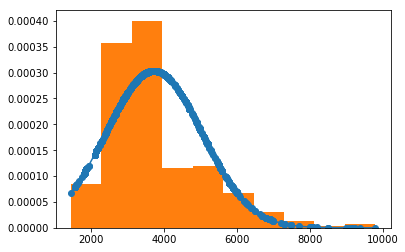

In [14]:
xs, ys = zip(*[x['loc']['coordinates'] for x in nearby])
prices = sorted([x['price'] for x in nearby if x['price'] < 10000])
fit = stats.norm.pdf(prices, np.mean(prices), np.std(prices))
plt.plot(prices, fit,'-o')
plt.hist(prices, normed=True)
plt.show()


# Scratchpad
[[back to top]](#Sections)

Copy listing, sans metadata, to dataframe.

In [7]:
%%time
c = collection.find({}, {'_id':0, 'id':0, 'building_id':0, 'manager_id':0, 'listing_id':0, 'photos':0})
raw_df = pd.DataFrame(list(c))
#raw_df.interest_level = raw_df.interest_level.astype('category', categories=['low', 'medium', 'high'])

CPU times: user 660 ms, sys: 964 ms, total: 1.62 s
Wall time: 12.7 s


In [8]:
import patsy
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from sklearn import model_selection
from sklearn import preprocessing

Use a fixed random seed to ensure results are repeatable.

In [9]:
random_state = 4444

### Helper functions

This is a dumb predictor. It's used as a baseline for evaluating models. It always guesses the most common outcome in the training set. 

In [10]:
class Baseline(object):
    def __init__(self, guess=None):
        self.guess = guess
        
    def fit(self, X, Y):
        self.guess = Counter(Y).most_common(1)[0][0]
        pass
    
    def predict(self, X):
        pred = np.array([self.guess] * len(X))
        return pred        
    
    def score(self, X, Y):
        return metrics.accuracy_score(Y, self.predict(X))
    
    def get_params(self, deep=False):
        return {'guess': self.guess}

In [11]:
def evaluate(models, X_train, y_train, X_test, y_test):
    headings = ['<b>{}</b>'.format(s) for s in stats.values()]
    d = OrderedDict({'' : headings})

    # Handle single model or list
    
    if not isinstance(models, list):
        models = [models]
    
    # Although cross_val_score uses StratifiedKFold automatically for
    # classification estimators, lets be explicit

    cv = model_selection.StratifiedKFold(n_splits=5, random_state=random_state)
    
    # Run models and collect stats
    
    for model in models:
        cv_scores = model_selection.cross_val_score(model, X_train, y_train, cv=5, scoring='f1_weighted')
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        precision = metrics.precision_score(y_test, y_pred)
        recall = metrics.recall_score(y_test, y_pred)
        f1 = metrics.f1_score(y_test, y_pred)
        scores = [round(np.mean(cv_scores), 3)] #+ [cm[stat] for stat in stats.keys() if stat]
        d[model.__class__.__name__] = scores
            
    return d

### Prepare training matricies

In [12]:
df_model = raw_df.copy()

Extract observations (X) and labels (y).

In [77]:
model_features = [
    'price', 'bedrooms', 'bathrooms', 'latitude', 'longitude'
]
X = df_model[model_features].copy()
y = df_model['interest_level'].copy()

Split data into training and test sets. The target classes are imbalanced, so I stratify the folds to preserve the percentage of samples.

In [78]:
TrainTestSplit = namedtuple('TrainTestSplit', 'X_train, X_test, y_train, y_test')
split_params = {'test_size' : .30, 'random_state' : random_state, 'stratify' : y}
train_test = TrainTestSplit(*model_selection.train_test_split(X, y, **split_params))

Verify the training and test sets have the same mix of target labels.

In [79]:
def report_mix(X, y, name):
    mix = y.value_counts() / sum(y.value_counts())
    pp_bold(name)
    pp_dict({ label : '{:.0%}'.format(mix[i]) for i, label in enumerate(mix.index)})

report_mix(train_test.X_train, train_test.y_train, 'Train')
report_mix(train_test.X_test, train_test.y_test, 'Test')

high,8%
medium,23%
low,69%


high,8%
medium,23%
low,69%


In [80]:
X_train, X_test = train_test.X_train, train_test.X_test
y_train, y_test = train_test.y_train, train_test.y_test

Try all algorithms

In [91]:
model = KNeighborsClassifier()
cv_scores = model_selection.cross_val_score(model, X_train, y_train, cv=5)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
cm = metrics.confusion_matrix(y_test, y_pred)


In [95]:
metrics.f1_score(y_test, y_pred, average=None)

array([ 0.2987436 ,  0.81234812,  0.26712459])

In [83]:
%%time
models = [
    Baseline(),
    KNeighborsClassifier(),
    LogisticRegression(random_state=random_state),
    SVC(random_state=random_state),
#    LinearSVC(random_state=random_state),
#    DecisionTreeClassifier(random_state=random_state),
#    RandomForestClassifier(random_state=random_state),
#    GaussianNB()
]

d = evaluate(models, X_train, y_train, X_test, y_test)    
pp_dictOflist(d)